<a href="https://colab.research.google.com/github/MosesIbe23/CSE_450_Private/blob/main/Copy_of_starter_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
housing

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,1565930130,20141104T000000,4,3.25,3760,4675,2.0,0,0,3,...,2740,1020,2007,0,98038,47.3862,-122.048,3280,4033,429900.0
1,3279000420,20150115T000000,3,1.75,1460,7800,1.0,0,0,2,...,1040,420,1979,0,98023,47.3035,-122.382,1310,7865,233000.0
2,194000575,20141014T000000,4,1.00,1340,5800,1.5,0,2,3,...,1340,0,1914,0,98116,47.5658,-122.389,1900,5800,455000.0
3,2115510160,20141208T000000,3,1.75,1440,8050,1.0,0,0,3,...,1440,0,1985,0,98023,47.3187,-122.390,1790,7488,258950.0
4,7522500005,20140815T000000,2,1.50,1780,4750,1.0,0,0,4,...,1080,700,1947,0,98117,47.6859,-122.395,1690,5962,555000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,5272200045,20141113T000000,3,1.50,1000,6914,1.0,0,0,3,...,1000,0,1947,0,98125,47.7144,-122.319,1000,6947,378000.0
19996,9578500790,20141111T000000,3,2.50,3087,5002,2.0,0,0,3,...,3087,0,2014,0,98023,47.2974,-122.349,2927,5183,399950.0
19997,7202350480,20140930T000000,3,2.50,2120,4780,2.0,0,0,3,...,2120,0,2004,0,98053,47.6810,-122.032,1690,2650,575000.0
19998,1723049033,20140620T000000,1,0.75,380,15000,1.0,0,0,3,...,380,0,1963,0,98168,47.4810,-122.323,1170,15000,245000.0


In [3]:

#Binning 'bedrooms' and 'sqft_living' into groups and categories respectively

housing['bedrooms'] = pd.cut(housing['bedrooms'], bins=[0, 2, 4, 6, np.inf], labels=['0-2', '3-4', '5-6', '7+'])
housing['bathrooms'] = pd.cut(housing['bathrooms'], bins=[0, 2, 4, 6, np.inf], labels=['0-1.75', '2-3.75', '4-5.75', '6+'])
housing['sqft_living'] = pd.cut(housing['sqft_living'], bins=[0, 1000, 2000, 3000, 4000, np.inf], labels=['0-999', '1000-1999', '2000-2999', '3000-3999', '4000+'])

housing

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,1565930130,20141104T000000,3-4,2-3.75,3000-3999,4675,2.0,0,0,3,...,2740,1020,2007,0,98038,47.3862,-122.048,3280,4033,429900.0
1,3279000420,20150115T000000,3-4,0-1.75,1000-1999,7800,1.0,0,0,2,...,1040,420,1979,0,98023,47.3035,-122.382,1310,7865,233000.0
2,194000575,20141014T000000,3-4,0-1.75,1000-1999,5800,1.5,0,2,3,...,1340,0,1914,0,98116,47.5658,-122.389,1900,5800,455000.0
3,2115510160,20141208T000000,3-4,0-1.75,1000-1999,8050,1.0,0,0,3,...,1440,0,1985,0,98023,47.3187,-122.390,1790,7488,258950.0
4,7522500005,20140815T000000,0-2,0-1.75,1000-1999,4750,1.0,0,0,4,...,1080,700,1947,0,98117,47.6859,-122.395,1690,5962,555000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,5272200045,20141113T000000,3-4,0-1.75,0-999,6914,1.0,0,0,3,...,1000,0,1947,0,98125,47.7144,-122.319,1000,6947,378000.0
19996,9578500790,20141111T000000,3-4,2-3.75,3000-3999,5002,2.0,0,0,3,...,3087,0,2014,0,98023,47.2974,-122.349,2927,5183,399950.0
19997,7202350480,20140930T000000,3-4,2-3.75,2000-2999,4780,2.0,0,0,3,...,2120,0,2004,0,98053,47.6810,-122.032,1690,2650,575000.0
19998,1723049033,20140620T000000,0-2,0-1.75,0-999,15000,1.0,0,0,3,...,380,0,1963,0,98168,47.4810,-122.323,1170,15000,245000.0


In [4]:

# Drop unnecessary columns: 'id' and 'date'
cleanhousing = housing.drop(columns=['id', 'date', 'yr_renovated'])

# Split features and target
X = cleanhousing.drop(columns=['price'])
y = cleanhousing['price']

# Convert categorical variables to numerical using one-hot encoding
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [5]:
xgb_model = XGBRegressor(random_state=42, n_estimators=50, max_depth=3)
xgb_model.fit(X_train_scaled, y_train)

y_pred = xgb_model.predict(X_test_scaled)

# Calculate evaluation metrics
mse = round(mean_squared_error(y_test, y_pred), 2)
mae = round(mean_absolute_error(y_test, y_pred), 2)
rmse = round(np.sqrt(mse), 2)
r2 = round(r2_score(y_test, y_pred)*100, 2)

# Print the results
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}%")

MSE: 19396781725.47
MAE: 80226.94
RMSE: 139272.33
R²: 87.14%


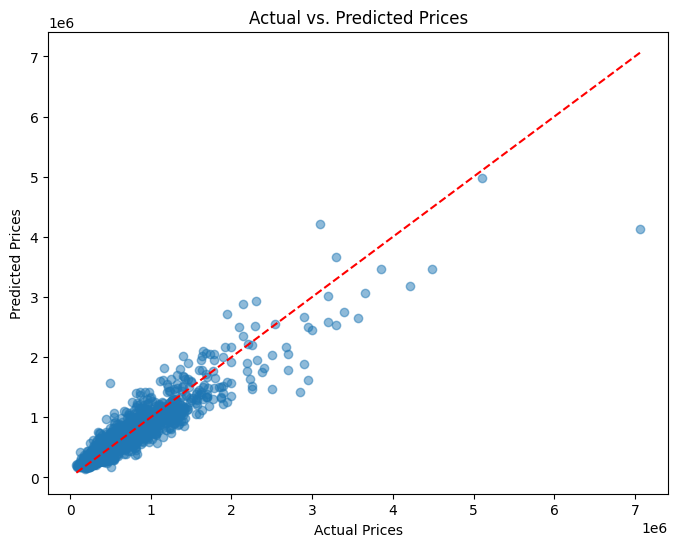

In [6]:
# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Diagonal line (perfect predictions)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices')
plt.show()

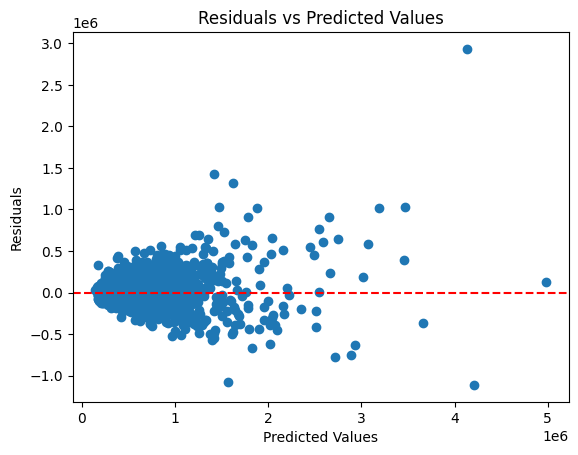

In [7]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

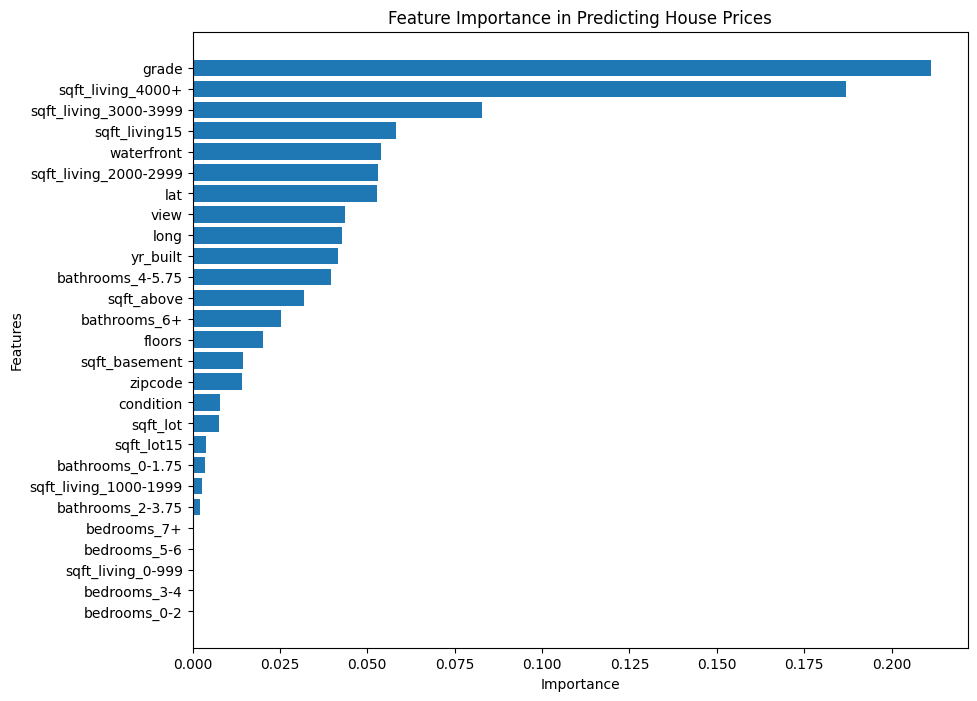

In [8]:
# Get feature importance from the trained XGBoost model
feature_importance = xgb_model.feature_importances_

# Create a bar chart to visualize feature importance
features = X.columns  # Get the column names
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Predicting House Prices')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important features at the top
plt.show()